In [1]:
"""
Improved Temporal Graph Neural Network for Anti-Money Laundering Detection
==========================================================================
Optimized for F2 Score with structured code organization
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool
from torch_geometric.data import Data, Batch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (precision_recall_curve, roc_auc_score, f1_score, 
                           precision_score, recall_score, fbeta_score, 
                           confusion_matrix, average_precision_score)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
import logging
warnings.filterwarnings('ignore')
import gc

In [2]:
from tqdm import tqdm
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))  # Adjust as needed
from config import DATAPATH, SAMPLE_DATAPATH

In [3]:
# Configure logging
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

In [4]:
class Config:
    """Configuration class for hyperparameters and settings"""
    # Model architecture
    HIDDEN_DIM = 128  # Increased from 128
    NODE_DIM = 15
    EDGE_DIM = 9
    DROPOUT_RATE = 0.3
    
    # Training parameters
    LEARNING_RATE = 0.0005  
    WEIGHT_DECAY = 1e-4
    EPOCHS = 100
    PATIENCE = 10  # Early stopping patience
    
    # F2 score optimization
    BETA = 2  # For F2 score (emphasizes recall)
    CLASS_WEIGHT_MULTIPLIER = 10  # Strong emphasis on minority class

    # Criterion parameters
    FOCAL_LOSS_ALPHA = 0.25
    FOCAL_LOSS_GAMMA = 2.0
    
    # Data processing
    TIME_WINDOW = '7D'
    VALIDATION_SPLIT = 0.17
    TEST_SPLIT = 0.13
    
    # Threshold optimization
    THRESHOLD_SEARCH_RANGE = np.arange(0.05, 0.95, 0.05)


In [5]:
def print_gpu_memory():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB")

def detailed_memory_profile():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        print(f"Allocated: {allocated:.2f}GB, Cached: {cached:.2f}GB")
        
        # Show memory summary
        # print(torch.cuda.memory_summary())
        return allocated, cached

In [6]:
class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance - better than BCE for F2 optimization"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

In [7]:
class TemporalGraphDataProcessor:
    """Enhanced data processor with better feature engineering for F2 optimization"""
    
    def __init__(self, time_window='7D'):
        self.time_window = time_window
        self.scalers = {}
        self.encoders = {}

    def load_and_preprocess(self, df):
        """Load SAML-D dataset and perform initial preprocessing"""
        print("Loading and preprocessing data...")
        
        # Combine date and time into datetime
        df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
        df = df.sort_values('datetime').reset_index(drop=True)
        
        print(f"Loaded {len(df)} transactions")
        print(f"Suspicious transactions: {df['Is_laundering'].sum()} ({df['Is_laundering'].mean()*100:.3f}%)")

        return df

    def engineer_features(self, df):
        """Enhanced feature engineering for better detection"""
        print("Engineering enhanced features...")
        
        # Time-based features (more granular)
        df['hour'] = df['datetime'].dt.hour.astype('int8')
        df['month'] = df['datetime'].dt.month.astype('int8')
        df['day_of_week'] = df['datetime'].dt.dayofweek.astype('int8')
        df['day_of_month'] = df['datetime'].dt.day.astype('int8')
        df['is_weekend'] = (df['day_of_week'] >= 5).astype('int8')
        df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 5)).astype('int8')  # Night transactions
        
        # Amount-based features
        df['log_amount'] = np.log1p(df['Amount']).astype('float32')
        
        # Calculate amount percentiles for anomaly detection
        # amount_percentiles = df['Amount'].quantile([0.95, 0.99]).values
        # df['high_amount'] = (df['Amount'] > amount_percentiles[0]).astype('int8')
        # df['very_high_amount'] = (df['Amount'] > amount_percentiles[1]).astype('int8')
        
        # Geographic risk features
        df['cross_border'] = (df['Payment_type'] == 'Cross-border').astype('int8')
        risky_countries = {'Mexico', 'Turkey', 'Morocco', 'UAE'}
        df['high_risk_sender'] = df['Sender_bank_location'].isin(risky_countries).astype('int8')
        df['high_risk_receiver'] = df['Receiver_bank_location'].isin(risky_countries).astype('int8')
        # df['both_high_risk'] = (df['high_risk_sender'] & df['high_risk_receiver']).astype('int8')
        
        # Currency features
        df['currency_mismatch'] = (df['Payment_currency'] != df['Received_currency']).astype('int8')
        
        # Convert target
        df['Is_laundering'] = df['Is_laundering'].astype('int8')
        
        # Clean up
        columns_to_drop = ['Date', 'Time', 'Amount', 'Sender_bank_location', 
                          'Receiver_bank_location', 'Payment_currency', 'Received_currency', 
                          'Laundering_type']
        df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
        
        return df

    def create_temporal_snapshots(self, df, account_features):
        """Create temporal graph snapshots with enhanced features"""
        print("Creating temporal graph snapshots...")
        
        # Global account mapping
        all_accounts = list(set(df['Sender_account'].unique()) | set(df['Receiver_account'].unique()))
        global_account_to_idx = {acc: idx for idx, acc in enumerate(all_accounts)}
        global_num_nodes = len(all_accounts)
        
        # Time windows
        start_date = df['datetime'].min().normalize().date()
        end_date = df['datetime'].max().normalize().date()
        
        snapshots = []
        print(f"Processing time range: {start_date} to {end_date}")

        for window_start in pd.date_range(start=start_date, end=end_date, freq=self.time_window, inclusive='left'):
            window_end = window_start + pd.Timedelta(days=7)
            window_start_str = pd.to_datetime(window_start).strftime('%Y-%m-%d')
            window_end_str = pd.to_datetime(window_end).strftime('%Y-%m-%d')
            print(f"Processing window: {window_start_str} to {window_end_str}")
            
            # Get transactions in current window
            window_mask = (df['datetime'] >= window_start_str) & (df['datetime'] < window_end_str)
            window_trnx_data = df[window_mask].copy()
            
            # Account features for this window
            window_accounts_features = account_features[account_features['window_start'] == window_start_str]
            
            if len(window_trnx_data) > 0:
                graph_data = self._create_graph_snapshot(
                    window_trnx_data, window_accounts_features,
                    window_start_str, global_account_to_idx, global_num_nodes
                )
                if graph_data is not None:
                    snapshots.append(graph_data)

        print(f"Created {len(snapshots)} temporal snapshots")
        return snapshots, global_num_nodes

    def _create_graph_snapshot(self, window_trnx_data, window_accounts_features, 
                              timestamp, global_account_to_idx, global_num_nodes):
        """Create enhanced graph snapshot"""
        if len(window_trnx_data) == 0:
            return None

        # Enhanced edge features
        edge_feature_columns = [
            'Payment_type_encoded', 'log_amount', 'month', 'day_of_week', 'hour', 
            'currency_mismatch', 'cross_border', 'high_risk_sender', 'high_risk_receiver',
        ]
        
        # Filter available columns
        edge_feature_columns = [col for col in edge_feature_columns if col in window_trnx_data.columns]

        # Node features
        node_feature_columns = ['sent_txns_count', 'fan_out', 'recv_txns_count', 'fan_in', 
                               'max_sent_txn_count', 'max_recv_txn_count', 'sent_recv_ratio', 
                               'fanout_fanin_ratio', 'log_med_sent_amt', 'log_std_sent_amt', 
                               'log_med_recv_amt', 'log_std_recv_amt', 'log_max_sent_txn_amt', 
                               'log_max_recv_txn_amt', 'log_total_txns_amt']

        # Create mappings and features
        sender_mapped = window_trnx_data['Sender_account'].map(global_account_to_idx)
        receiver_mapped = window_trnx_data['Receiver_account'].map(global_account_to_idx)
        edge_index = np.column_stack((sender_mapped, receiver_mapped))
        edge_features = window_trnx_data[edge_feature_columns].values
        transaction_labels = window_trnx_data['Is_laundering'].values

        # Node features
        node_features = np.zeros((global_num_nodes, len(node_feature_columns)))
        try:
            window_accounts_features['global_idx'] = window_accounts_features['account'].map(global_account_to_idx)
            node_features[window_accounts_features['global_idx'].values] = window_accounts_features[node_feature_columns].values
        except: 
            raise ValueError("Error in mapping account features to global indices.")

        # Convert to tensors
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        node_features = torch.tensor(node_features, dtype=torch.float)
        edge_features = torch.tensor(edge_features, dtype=torch.float)
        transaction_labels = torch.tensor(transaction_labels, dtype=torch.float)

        return Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_features,
            y=transaction_labels,
            timestamp=timestamp,
            num_nodes=global_num_nodes
        )

In [8]:
# Temporal GNN Model for Edge Classification
class TemporalEdgeClassifier(nn.Module):
    def __init__(self, node_dim, edge_dim, hidden_dim, dropout_rate):
        super(TemporalEdgeClassifier, self).__init__()
        
        self.rnn = nn.GRUCell(node_dim, hidden_dim)
        self.gnn1 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
        self.gnn2 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
        self.gnn3 = SAGEConv(hidden_dim, hidden_dim, aggr='mean')
        self.dropout = nn.Dropout(p=dropout_rate)
        # Improved classifier architecture
        # self.classifier = nn.Linear(hidden_dim * 2 + edge_dim, 1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
        self.edge_encoder = nn.Sequential(
            nn.Linear(edge_dim, hidden_dim),  # Project to hidden_dim
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),  # Normalize
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim)  # Second layer for non-linearity
        )

    def forward(self, data, h):
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        
        # Update node hidden states with RNN (using current x)
        h = self.rnn(x, h)
        
        # Apply GNN layers
        h = F.relu(self.gnn1(h, edge_index))
        h = self.dropout(h)
        h = F.relu(self.gnn2(h, edge_index))
        h = self.dropout(h)
        h = F.relu(self.gnn3(h, edge_index))
        h = self.dropout(h)

        # Process edge_attr
        edge_attr = self.edge_encoder(edge_attr)

        # Edge features: concat sender h, receiver h, edge_attr
        h_i = h[edge_index[0]]
        h_j = h[edge_index[1]]
        edge_input = torch.cat([h_i, h_j, edge_attr], dim=-1)
        
        # Prediction
        out = self.classifier(edge_input)
        
        return out, h  # Return logits and updated h

In [9]:
class ModelTrainer:
    """Enhanced trainer class optimized for F2 score"""
    
    def __init__(self, config=Config(), mem_profile=False):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        self.mem_profile = mem_profile

    def find_optimal_threshold(self, probs, labels):
        """Find optimal threshold for F2 score"""
        best_f2 = 0
        best_threshold = 0.5
        
        for threshold in self.config.THRESHOLD_SEARCH_RANGE:
            preds = (probs >= threshold).astype(int)
            f2 = fbeta_score(labels, preds, beta=self.config.BETA, average='binary', zero_division=0)
            if f2 > best_f2:
                best_f2 = f2
                best_threshold = threshold
        
        return best_threshold, best_f2
    
    def compute_class_weights(self, snapshots):
        """Compute class weights for focal loss"""
        all_labels = []
        for snap in snapshots:
            all_labels.extend(snap.y.cpu().numpy())
        
        all_labels = np.array(all_labels)
        pos_weight = len(all_labels) / (2 * np.sum(all_labels))
        return torch.tensor(pos_weight, dtype=torch.float).to(self.device)
    
    def train_model(self, snapshots, global_num_nodes):
        """Enhanced training with F2 optimization"""
        
        # Split data
        train_size = int(len(snapshots) * (1 - self.config.VALIDATION_SPLIT - self.config.TEST_SPLIT))
        val_size = int(len(snapshots) * self.config.VALIDATION_SPLIT)
        
        train_snaps = snapshots[:train_size]
        val_snaps = snapshots[train_size:train_size + val_size]
        test_snaps = snapshots[train_size + val_size:]
        
        print(f"Data split - Train: {len(train_snaps)}, Val: {len(val_snaps)}, Test: {len(test_snaps)}")
        
        # Initialize model
        model = TemporalEdgeClassifier(
            self.config.NODE_DIM, 
            self.config.EDGE_DIM, 
            self.config.HIDDEN_DIM,
            self.config.DROPOUT_RATE
        ).to(self.device)
        
        # Compute class weights for focal loss
        pos_weight = self.compute_class_weights(train_snaps)
        criterion = FocalLoss(alpha=self.config.FOCAL_LOSS_ALPHA, gamma=self.config.FOCAL_LOSS_GAMMA)
        
        # Optimizer with different learning rates for different components
        optimizer = torch.optim.AdamW([
            {'params': model.rnn.parameters(), 'lr': self.config.LEARNING_RATE * 0.5},
            {'params': model.gnn1.parameters(), 'lr': self.config.LEARNING_RATE},
            {'params': model.gnn2.parameters(), 'lr': self.config.LEARNING_RATE},
            {'params': model.gnn3.parameters(), 'lr': self.config.LEARNING_RATE},
            {'params': model.edge_encoder.parameters(), 'lr': self.config.LEARNING_RATE},
            {'params': model.classifier.parameters(), 'lr': self.config.LEARNING_RATE * 1.5}
        ], weight_decay=self.config.WEIGHT_DECAY)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, verbose=True
        )
        
        # Training loop
        best_f2_score = 0
        patience_counter = 0
        train_loss_history = []
        val_loss_history = []
        f2_history = []
        
        for epoch in range(self.config.EPOCHS):
            # Training
            model.train()
            train_loss = 0
            h = torch.zeros(global_num_nodes, self.config.HIDDEN_DIM).to(self.device)

            if self.mem_profile:
                print(f"=== EPOCH {epoch} START ===")
                epoch_start_mem = detailed_memory_profile()
                print(f"Epoch Mem Allocated: {epoch_start_mem[0]:.3f} GB, Cached: {epoch_start_mem[0]:.3f} GB")

            for i, snap in enumerate(train_snaps):
                if (i < 5) and self.mem_profile:
                    print(f"--- Snapshot {i} ---")
                    pre_snap = detailed_memory_profile()
                    print(f"Pre snap Allocated: {pre_snap[0]:.3f} GB, Cached: {pre_snap[0]:.3f} GB")
                
                snap = snap.to(self.device)
                optimizer.zero_grad()
                
                out, h = model(snap, h.detach())  # Detach to prevent gradient explosion
                loss = criterion(out.squeeze(), snap.y)

                if (i < 5) and self.mem_profile:
                    post_forward = detailed_memory_profile()
                    print(f"Forward Mem Allocated: {post_forward[0]}, Cached: {post_forward[1]:.3f}GB cached")
                    print(f"Forward pass added: {post_forward[1] - pre_snap[1]:.3f}GB cached")
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                optimizer.step()

                if (i < 5) and self.mem_profile:
                    post_backward = detailed_memory_profile()
                    print(f"Forward Mem Allocated: {post_backward[0]}, Cached: {post_backward[1]:.3f}GB cached")
                    print(f"Backward pass added: {post_backward[1] - post_forward[1]:.3f}GB cached")
                
                train_loss += loss.item()
            
            avg_train_loss = train_loss / len(train_snaps)
            train_loss_history.append(avg_train_loss)
            
            # Validation
            model.eval()
            val_probs_list, val_labels_list = [], []
            val_loss = 0
            
            with torch.no_grad():
                h = torch.zeros(global_num_nodes, self.config.HIDDEN_DIM).to(self.device)
                for snap in val_snaps:
                    snap = snap.to(self.device)
                    out, h = model(snap, h)
                    loss = criterion(out.squeeze(), snap.y)
                    val_loss += loss.item()
                    
                    preds = torch.sigmoid(out).squeeze()
                    val_probs_list.append(preds.cpu())
                    val_labels_list.append(snap.y.cpu())
            
            avg_val_loss = val_loss / len(val_snaps)
            val_loss_history.append(avg_val_loss)
            
            # Calculate F2 score with optimal threshold
            val_probs = torch.cat(val_probs_list).numpy()
            val_labels = torch.cat(val_labels_list).numpy()
            
            optimal_threshold, f2_score = self.find_optimal_threshold(val_probs, val_labels)
            f2_history.append(f2_score)
            recall = recall_score(val_labels, (val_probs >= optimal_threshold).astype(int), zero_division=0)
            
            # Update scheduler with F2 score
            # scheduler.step(f2_score)
            scheduler.step(avg_val_loss)
            
            # Early stopping based on F2 score
            if f2_score > best_f2_score:
                best_f2_score = f2_score
                patience_counter = 0
                # Save best model
                # torch.save(model.state_dict(), './outputs/best_model.pth')
            else:
                patience_counter += 1
            
            # if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}: Train Loss(x1e3): {1000*avg_train_loss:.4f}, Val Loss(x1e3): {1000*avg_val_loss:.4f}, "
                        f"F2: {f2_score:.4f}, Threshold: {optimal_threshold:.3f}, Recall: {recall:.4f}, "
                        f"LR: {current_lr:.6f}")

            if patience_counter >= self.config.PATIENCE:
                print("Early stopping triggered.")
                break
        
        # Load best model and evaluate
        # model.load_state_dict(torch.load('./outputs/best_model.pth'))
        
        # Final evaluation
        results = self._evaluate_model(model, train_snaps, val_snaps, test_snaps, global_num_nodes)
        results.update({
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history,
            'f2_history': f2_history,
            'model': model
        })
        
        return results
    
    def _evaluate_model(self, model, train_snaps, val_snaps, test_snaps, global_num_nodes):
        """Comprehensive model evaluation"""
        model.eval()
        results = {}
        
        for split_name, snaps in [('val', val_snaps), ('test', test_snaps)]:
            probs_list, labels_list = [], []
            
            with torch.no_grad():
                h = torch.zeros(global_num_nodes, self.config.HIDDEN_DIM).to(self.device)
                for snap in snaps:
                    snap = snap.to(self.device)
                    out, h = model(snap, h)
                    preds = torch.sigmoid(out).squeeze().cpu().numpy()
                    probs_list.extend(preds)
                    labels_list.extend(snap.y.cpu().numpy())
            
            probs = np.array(probs_list)
            labels = np.array(labels_list)
            
            # Find optimal threshold
            optimal_threshold, best_f2 = self.find_optimal_threshold(probs, labels)
            binary_preds = (probs >= optimal_threshold).astype(int)
            
            # Calculate metrics
            precision = precision_score(labels, binary_preds, zero_division=0)
            recall = recall_score(labels, binary_preds, zero_division=0)
            f1 = f1_score(labels, binary_preds, zero_division=0)
            roc_auc = roc_auc_score(labels, probs)
            pr_auc = average_precision_score(labels, probs)
            
            results[f'{split_name}_probs'] = probs
            results[f'{split_name}_labels'] = labels
            results[f'{split_name}_threshold'] = optimal_threshold
            results[f'{split_name}_precision'] = precision
            results[f'{split_name}_recall'] = recall
            results[f'{split_name}_f1'] = f1
            results[f'{split_name}_f2'] = best_f2
            results[f'{split_name}_roc_auc'] = roc_auc
            results[f'{split_name}_pr_auc'] = pr_auc
        
        return results

In [10]:
# Load the entire dataset
df = pd.read_csv(DATAPATH)

# Filter by data range
# df = df[df['Date'] < '2023-08-18']
# df = df.head(300000).copy()

# run feature engg.ipynb to get the account_stats_7D.csv
account_stats = pd.read_csv('../account_stats_7D.csv')

In [11]:
graph_processor = TemporalGraphDataProcessor()
df = graph_processor.load_and_preprocess(df)
df = graph_processor.engineer_features(df)

Loading and preprocessing data...
Loaded 9504852 transactions
Suspicious transactions: 9873 (0.104%)
Engineering enhanced features...


In [12]:
from sklearn.preprocessing import LabelEncoder

# For each categorical column
# categorical_cols = ['Payment_currency', 'Received_currency', 'Sender_bank_location', 
#                    'Receiver_bank_location', 'Payment_type']
categorical_cols = ['Payment_type']

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
    
# Drop original object columns
df = df.drop(categorical_cols, axis=1)

In [13]:
# Process accont_stats
columns = ['med_sent_amt', 'std_sent_amt', 'med_recv_amt', 'std_recv_amt', 
           'max_sent_txn_amt', 'max_recv_txn_amt', 'total_txns_amt']

for col in columns:
    account_stats['log_' + col] = np.log1p(account_stats[col]).astype('float32')

account_stats = account_stats.drop(columns, axis=1)

In [14]:
# Set data types to optimize memory
account_stats = account_stats.astype({
    'sent_txns_count': 'int32',
    'recv_txns_count': 'int32',
    'fan_out': 'int32',
    'fan_in': 'int32',
    'max_sent_txn_count': 'int32',
    'max_recv_txn_count': 'int32',
    'sent_recv_ratio': 'float32',
    'fanout_fanin_ratio': 'float32'
})

In [15]:
snapshots, global_num_nodes = graph_processor.create_temporal_snapshots(df, account_stats)

Creating temporal graph snapshots...
Processing time range: 2022-10-07 to 2023-08-23
Processing window: 2022-10-07 to 2022-10-14
Processing window: 2022-10-14 to 2022-10-21
Processing window: 2022-10-21 to 2022-10-28
Processing window: 2022-10-28 to 2022-11-04
Processing window: 2022-11-04 to 2022-11-11
Processing window: 2022-11-11 to 2022-11-18
Processing window: 2022-11-18 to 2022-11-25
Processing window: 2022-11-25 to 2022-12-02
Processing window: 2022-12-02 to 2022-12-09
Processing window: 2022-12-09 to 2022-12-16
Processing window: 2022-12-16 to 2022-12-23
Processing window: 2022-12-23 to 2022-12-30
Processing window: 2022-12-30 to 2023-01-06
Processing window: 2023-01-06 to 2023-01-13
Processing window: 2023-01-13 to 2023-01-20
Processing window: 2023-01-20 to 2023-01-27
Processing window: 2023-01-27 to 2023-02-03
Processing window: 2023-02-03 to 2023-02-10
Processing window: 2023-02-10 to 2023-02-17
Processing window: 2023-02-17 to 2023-02-24
Processing window: 2023-02-24 to 20

In [24]:
torch.cuda.empty_cache()
print_gpu_memory()

GPU Memory - Allocated: 2.71GB, Cached: 2.85GB


In [17]:
trainer = ModelTrainer(config=Config(), mem_profile=False)
results = trainer.train_model(snapshots, global_num_nodes)

Using device: cuda
Data split - Train: 32, Val: 7, Test: 7
Epoch 1: Train Loss(x1e3): 7.6154, Val Loss(x1e3): 1.2564, F2: 0.0007, Threshold: 0.050, Recall: 0.0007, LR: 0.000250
Epoch 2: Train Loss(x1e3): 0.8394, Val Loss(x1e3): 0.6776, F2: 0.0143, Threshold: 0.150, Recall: 0.1084, LR: 0.000250
Epoch 3: Train Loss(x1e3): 0.6819, Val Loss(x1e3): 0.6209, F2: 0.0190, Threshold: 0.100, Recall: 0.2791, LR: 0.000250
Epoch 4: Train Loss(x1e3): 0.6473, Val Loss(x1e3): 0.5932, F2: 0.0238, Threshold: 0.100, Recall: 0.3457, LR: 0.000250
Epoch 5: Train Loss(x1e3): 0.6227, Val Loss(x1e3): 0.5711, F2: 0.0291, Threshold: 0.100, Recall: 0.4328, LR: 0.000250
Epoch 6: Train Loss(x1e3): 0.5996, Val Loss(x1e3): 0.5445, F2: 0.0401, Threshold: 0.150, Recall: 0.1310, LR: 0.000250
Epoch 7: Train Loss(x1e3): 0.5671, Val Loss(x1e3): 0.5099, F2: 0.0676, Threshold: 0.150, Recall: 0.1996, LR: 0.000250
Epoch 8: Train Loss(x1e3): 0.5311, Val Loss(x1e3): 0.4684, F2: 0.1106, Threshold: 0.150, Recall: 0.3697, LR: 0.0002

In [18]:
results

{'val_probs': array([0.09969815, 0.06114856, 0.00705266, ..., 0.00987016, 0.00627424,
        0.01236532], shape=(1458820,), dtype=float32),
 'val_labels': array([0., 0., 0., ..., 0., 0., 0.], shape=(1458820,), dtype=float32),
 'val_threshold': np.float64(0.35000000000000003),
 'val_precision': 0.7743988684582744,
 'val_recall': 0.7510288065843621,
 'val_f1': 0.7625348189415042,
 'val_f2': 0.7555892906431134,
 'val_roc_auc': 0.9943030059467296,
 'val_pr_auc': 0.7904635965618241,
 'test_probs': array([0.00065623, 0.00420685, 0.00258708, ..., 0.00647344, 0.32142994,
        0.02155951], shape=(1384809,), dtype=float32),
 'test_labels': array([0., 0., 0., ..., 0., 0., 0.], shape=(1384809,), dtype=float32),
 'test_threshold': np.float64(0.45),
 'test_precision': 0.829817158931083,
 'test_recall': 0.7190737355271176,
 'test_f1': 0.7704864511916422,
 'test_f2': 0.7387928875532181,
 'test_roc_auc': 0.9934699604951088,
 'test_pr_auc': 0.7852232601718753,
 'train_loss_history': [0.0076154128146

In [19]:
from sklearn.metrics import confusion_matrix


# Function to compute and print confusion matrix
def compute_confusion_matrix(labels, preds, threshold=0.5):

    # Convert probabilities to binary predictions using the threshold
    binary_preds = (preds >= threshold).astype(int)

    # Compute confusion matrix
    cm = confusion_matrix(labels, binary_preds)
    
    print("Confusion Matrix:")
    print(cm)
    
    # Optional: Extract and print TP, TN, FP, FN
    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    print(f"Precision: {tp / (tp + fp + 1e-8):.4f}")
    print(f"Recall: {tp / (tp + fn + 1e-8):.4f}")

In [20]:
test_probs = results['test_probs']
test_labels = results['test_labels']
val_probs = results['val_probs']
val_labels = results['val_labels']

In [27]:
compute_confusion_matrix(val_labels, val_probs, threshold=0.15)

Confusion Matrix:
[[1449146    8216]
 [    196    1262]]
True Negatives (TN): 1449146
False Positives (FP): 8216
False Negatives (FN): 196
True Positives (TP): 1262
Precision: 0.1332
Recall: 0.8656


In [28]:
compute_confusion_matrix(test_labels, test_probs, threshold=0.15)

Confusion Matrix:
[[1373370    9798]
 [    181    1460]]
True Negatives (TN): 1373370
False Positives (FP): 9798
False Negatives (FN): 181
True Positives (TP): 1460
Precision: 0.1297
Recall: 0.8897


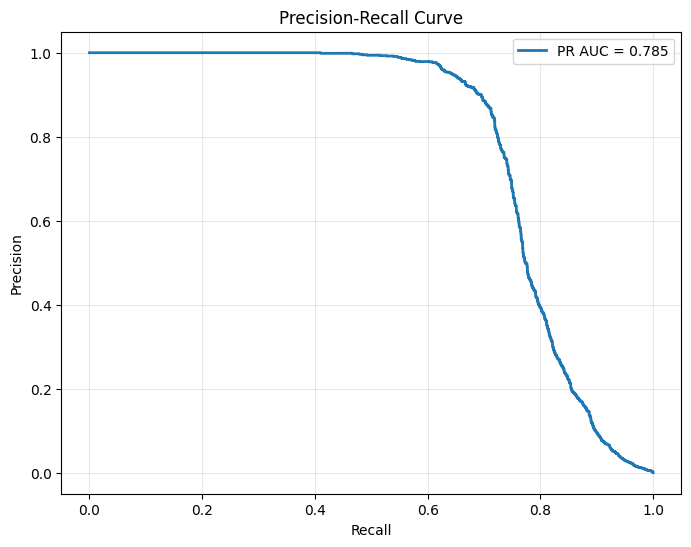

PR AUC Score: 0.7852


In [23]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate PR curve data
precision, recall, thresholds = precision_recall_curve(test_labels, test_probs)
pr_auc = average_precision_score(test_labels, test_probs)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label=f'PR AUC = {pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"PR AUC Score: {pr_auc:.4f}")